In [16]:
from ungol.models import embcodr
from ungol.models import embcompr
from ungol.similarity import rhwmd
from ungol.common import embed as uce
from ungol.sentemb import redux as usr

import torch
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt

import pathlib

In [2]:
DEV = torch.device('cpu')
P_ROOT = pathlib.Path('../opt')

In [3]:
f_model = 'experiments/19.01.23/enwiki_1m.mbow-256/compressor/'
compr = embcompr.Compressor.load(P_ROOT / f_model, 'model.torch', DEV)
compr.eval()

print(compr)

Neural Compressor Version 0.2
Compressor(
  (_encoder): Encoder(
    (_gumbel): Gumbel()
    (_layer): Sequential(
      (fcl1): Linear(in_features=300, out_features=256, bias=True)
      (fcl1-a): Tanh()
      (fcl2): Linear(in_features=256, out_features=512, bias=True)
      (fcl2-a): Softplus(beta=1, threshold=20)
    )
  )
  (_decoder): QuantizationDecoder()
)


In [4]:
embed = uce.create(uce.Config(
    provider='h5py',
    file_name=P_ROOT / 'embed/glove-840b.2m.300d.h5',
    vocabulary=P_ROOT / 'embed/glove-840b.2m.300d.vocab.pickle'
))

print(embed)

ungol embedding provider
  2196016 words
  300 dimensions


In [20]:
redux = usr.MBoW(embed)

def sim_cosine(s1, s2):
    norm = np.linalg.norm(s1) * np.linalg.norm(s2)
    return 1 - (((np.dot(s1, s2) / norm) + 1) / 2)


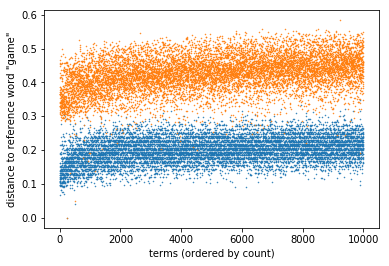

In [38]:
word = 'game'
amount = 10_000

word_emb = torch.Tensor([redux.do([word])])
word_code = embcodr.create_codes(compr, word_emb, 256)
word_hash = embcodr.create_hashes(word_code)[0].astype(np.uint8)

toks = [[embed.lookup[i], word] for i in range(amount)]
embs = torch.Tensor([redux.do(t) for t in toks]).to(device=DEV)

codes = embcodr.create_codes(compr, embs, 256)
hashes = embcodr.create_hashes(codes).astype(np.uint8)

rows = []
for i in range(amount):
    rows.append((
        i,
        ' '.join(toks[i]),
        rhwmd.hamming(hashes[i], word_hash),
        sim_cosine(embed[word], embed[i])
    ))

cols = list(zip(*rows))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('terms (ordered by count)')
ax.set_ylabel(f'distance to reference word "{word}"')

ax.scatter(range(amount), cols[2], marker='.', s=1)
ax.scatter(range(amount), cols[3], marker='.', s=1)

plt.show(fig)
plt.close(fig)

# print(tabulate(rows))
